# Part 3 - Predictive Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Data

In [2]:
df=pd.read_json('../ultimate_challenge/ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We can see that 3 columns from 12 columns have null values. We need to take care of these columns which are
'avg_rating_of_driver', 'phone', 'avg_rating_by_driver'.

'signup_date' and 'last_trip_date' are supposed to be date format but they are object. Wee need to convert them

In [5]:
df['last_trip_date']=pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

Let's get rid of null values of phone.

In [7]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

We have 2 type of phone. We can replace null values with other.

In [8]:
df.phone.fillna('Other', inplace=True)
df.phone.value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

We need to take care of other 2 columns which have missing values. 'avg_rating_by_driver' has very less null value numbers 
we can drom these rows but I don't wanna drop rows. I will fill nan values in these 2 columns with avarage numbers.

In [9]:
df=df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

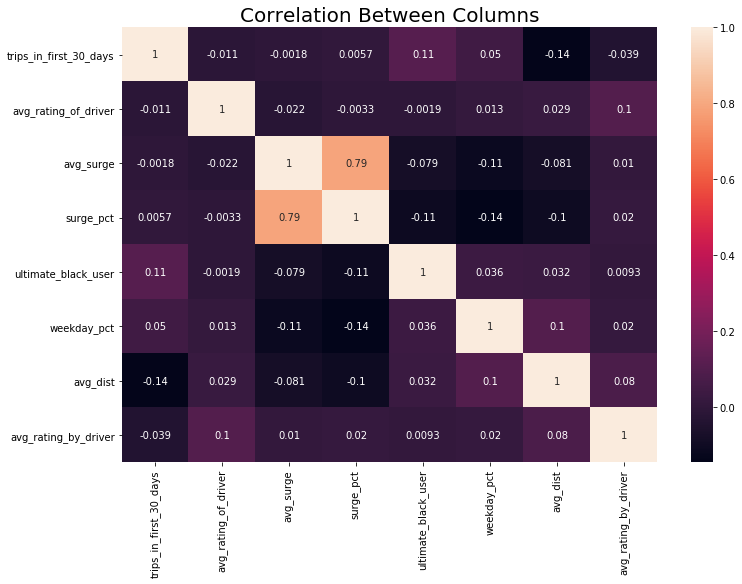

In [10]:
fig, ax = plt.subplots(figsize = (12,8))
ax = plt.subplot(111)
corr = df.corr()
ax = sns.heatmap(corr,annot=True)
ax.set_title('Correlation Between Columns',fontsize=20)
plt.show()

I will convert object columns to binary columns for machine learning.

In [11]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

So we have only 3 different type of values in 2 columns(city and phone) which have object data types. I can use get_dummies.

In [12]:
df=pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   ultimate_black_user     50000 non-null  bool          
 7   weekday_pct             50000 non-null  float64       
 8   avg_dist                50000 non-null  float64       
 9   avg_rating_by_driver    50000 non-null  float64       
 10  city_Astapor            50000 non-null  uint8         
 11  city_King's Landing     50000 non-null  uint8         
 12  city_Winterfell         50000 non-null  uint8 

In [13]:
# find the date the data was pulled
pull_date = df.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
df['active_status'] = (df.last_trip_date > cut_off_day).astype('int')

In [14]:
df.active_status.head()

0    1
1    0
2    0
3    1
4    0
Name: active_status, dtype: int64

# Modeling

In [15]:
feature_cols=df.drop(['active_status','last_trip_date','signup_date'],axis=1)
X=feature_cols
y=df['active_status']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3,random_state=123)

In [16]:
parameters = {
    'max_depth':[3,5,8],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1]
    }

# Instantiate a Gradient Boosting Classifier
clf = GradientBoostingClassifier()

# Instantiate the GridSearchCV object
clf_grid = GridSearchCV(clf, param_grid=parameters,scoring='accuracy',cv=5)

# Fit it to the data
clf_grid.fit(X_train, y_train)

# Print the tuned parameters and score
print("Best Parameters: {}".format(clf_grid.best_params_)) 
print("Best accuracy is {}".format(clf_grid.best_score_))

pred= clf_grid.predict(X_test)
score = accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'subsample': 0.8}
Best accuracy is 0.7929428571428572
Accuracy score: 0.7958666666666666


In [17]:
# use default parameters
clf_default = GradientBoostingClassifier()
# Fit it to the data
clf_default.fit(X_train, y_train)

pred= clf_default.predict(X_test)
score = accuracy_score(y_test, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.7895333333333333


In [18]:
importances = clf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

Feature ranking:
1. feature 7 (0.278051)
2. feature 9 (0.139671)
3. feature 3 (0.116556)
4. feature 5 (0.115677)
5. feature 6 (0.067223)
6. feature 4 (0.059656)
7. feature 0 (0.058075)
8. feature 11 (0.051164)
9. feature 1 (0.032634)
10. feature 2 (0.026521)
11. feature 8 (0.025660)
12. feature 13 (0.024706)
13. feature 10 (0.003575)
14. feature 12 (0.000829)


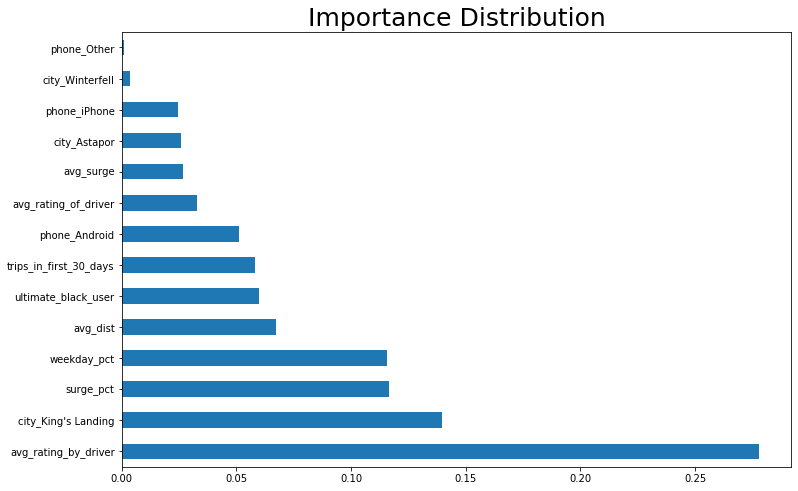

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
(pd.Series(importances, index=X.columns).nlargest(14).plot(kind='barh'))
ax.set_title('Importance Distribution',fontsize=25)
plt.show()

# Conclusion

The best parameters produced the best performing XGBoost model, resulting in a classification accuracy of 79.58% for the test data. The factors that most heavily influence rider retention are the riders' average rating of their drivers over all of their trips.